# Causal Inference Between Two Variables

## Setup

In [8]:
import math
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import seaborn as sns
from abc import abstractmethod
from matplotlib.ticker import NullFormatter, NullLocator, MultipleLocator
%matplotlib inline
from sklearn.svm import SVR
from hyppo.independence import Hsic

## Causal Data Generation, Visualization, and Inference

### Data Generator


The ```noise``` function generates noise variable according to ```dist``` distribution. Moreover, the ```get_data``` function simulates $Y = f(X) + N_Y$.


In [9]:
def noise(size, dist, val, df = 1):
    if dist == 'normal':
        return rnd.normal(size = size)
    if dist == 'uniform':
        return rnd.uniform(0, 1, size = size)
    if dist == 't dist':
        return rnd.standard_t(df = df, size = size)
    if dist == 'interventional':
        return np.full(size, val)
    
def get_data(size, dist_Nx, dist_Ny, f, val_x = None, val_y = None, df = 1):
    X = noise(size, dist_Nx, val_x, df)
    Ny = noise(size, dist_Ny, val_y, df)
    Y = f(X) + Ny
    return X, Y

In [10]:
def plot_observational(size, dist_Nx, dist_Ny, f, Ngrid, Xgrid = None, Ygrid = None, df = 1):
    x, y = get_data(size, dist_Nx, dist_Ny, f, df = df)

    if Xgrid is None:
        H, xbins, ybins = np.histogram2d(x, y, Ngrid)
    else:
        H, xbins, ybins = np.histogram2d(x, y, [Xgrid, Ygrid])
        
    H /= np.sum(H)

    fig = plt.figure(figsize=(12, 8))

    ax_Pxy = plt.axes((0, 0.34, 0.27, 0.52))
    ax_Px = plt.axes((0, 0.14, 0.27, 0.2))
    ax_Py = plt.axes((-0.1, 0.34, 0.1, 0.52))
    ax_cb = plt.axes((0.28, 0.34, 0.01, 0.52))
    ax_Px_y = [plt.axes((0.45, 0.7, 0.22, 0.16)),
           plt.axes((0.45, 0.5, 0.22, 0.16)),
           plt.axes((0.45, 0.3, 0.22, 0.16))]
    ax_Py_x = [plt.axes((0.75, 0.7, 0.22, 0.16)),
           plt.axes((0.75, 0.5, 0.22, 0.16)),
           plt.axes((0.75, 0.3, 0.22, 0.16))]

    ax_Px_y[0].xaxis.set_major_formatter(NullFormatter())
    ax_Px_y[1].xaxis.set_major_formatter(NullFormatter())
    ax_Py_x[0].xaxis.set_major_formatter(NullFormatter())
    ax_Py_x[1].xaxis.set_major_formatter(NullFormatter())
    ax_Pxy.xaxis.set_major_formatter(NullFormatter())
    ax_Pxy.yaxis.set_major_formatter(NullFormatter())
    ax_Px.yaxis.set_major_formatter(NullFormatter())
    ax_Py.xaxis.set_major_formatter(NullFormatter())

    plt.axes(ax_Pxy)
    H *= 1000
    plt.imshow(H.T, interpolation='nearest', origin='lower', aspect='auto',
           cmap=plt.cm.binary)

    cb = plt.colorbar(cax=ax_cb)
    plt.text(0, 1.02, r'$\times 10^{-3}$', transform=ax_cb.transAxes)

    ax_Px.plot(xbins[1:], H.sum(1), '-k', drawstyle='steps')
    ax_Py.plot(H.sum(0), ybins[1:], '-k', drawstyle='steps')

    ax_Pxy.set_xlabel('$x$')
    ax_Pxy.set_ylabel('$y$')
    ax_Px.set_xlabel('$x$')
    ax_Px.set_ylabel('$p_X(x)$')
    ax_Px.yaxis.set_label_position('right')
    ax_Py.set_ylabel('$y$')
    ax_Py.set_xlabel('$p_Y(y)$')
    ax_Py.xaxis.set_label_position('top')

    axis = ax_Pxy.axis()

    for i in range(3):
        Px_y = H[:, idx[i]] / H[:, idx[i]].sum()
        ax_Px_y[i].plot(xbins[1:], Px_y, drawstyle='steps', c=colors[i])

        ax_Px_y[i].yaxis.set_major_formatter(NullFormatter())
        ax_Px_y[i].set_ylabel('$p_{X|Y}(x | y = %.1f)$' % ybins[idx[i]])
    ax_Pxy.axis(axis)
    ax_Px_y[2].set_xlabel('$x$')

    for i in range(3):
        Py_x = H[idx[i]] / H[idx[i]].sum()
        ax_Py_x[i].plot(ybins[1:], Py_x, drawstyle='steps', c=colors[i])
        ax_Py_x[i].yaxis.set_major_formatter(NullFormatter())
        ax_Py_x[i].set_ylabel('$p_{Y|X}(y | x = %.1f)$' % xbins[idx[i]])
    ax_Py_x[2].set_xlabel('$y$')

    ax_Pxy.set_title('Joint Probability')
    ax_Px_y[0].set_title('Conditional Probability')
    ax_Py_x[0].set_title('Conditional Probability')

    plt.grid(False)
    plt.show()
    
    return xbins, ybins

In [32]:
def fit(input, target):
    svr = SVR(kernel = 'rbf', C = 1000, gamma = 'auto', epsilon = 0.1, coef0 = 1)
    svr.fit(input, target)
    residual = svr.predict(input) - target
    return residual

In [33]:
Ngrid = 600
n = 10
idx = [3 * Ngrid // 4, Ngrid // 2, Ngrid // 4]
colors = 'rgb'

### Model A

$X := N_X, Y := X^3 + X + N_X$
$\newcommand{\indep}{\perp \!\!\! \perp}$

$N_X \indep N_Y$ 

$N_X, N_Y \sim \mathcal{N}(0, 1)$

##### Observational Data

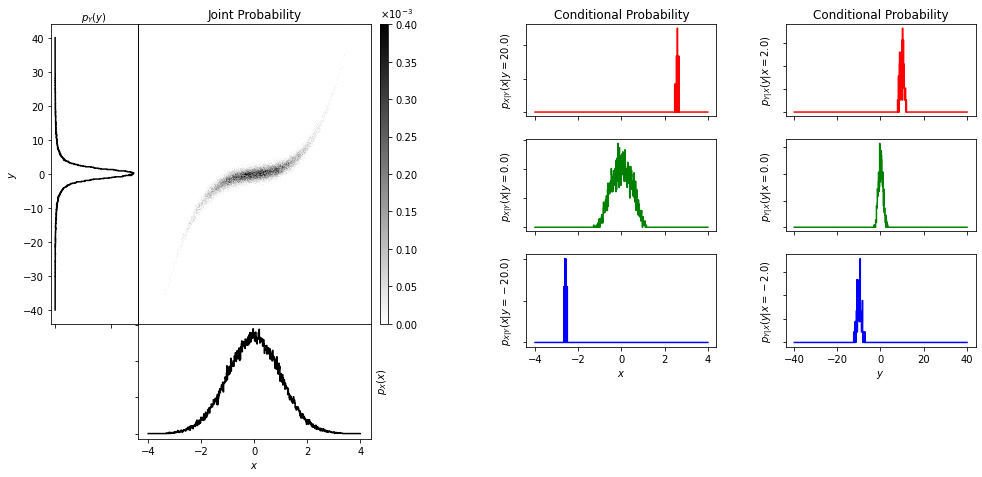

In [43]:
Xgrid = np.linspace(-4, 4, Ngrid + 1)
Ygrid = np.linspace(-40, 40, Ngrid + 1)
xbins, ybins = plot_observational(100000, 'normal', 'normal', lambda x: x**3 + x, Ngrid, Xgrid, Ygrid)

As you see in the conditional probablity plots, $P_{X|Y} (x|y)$ depends on different choices of $y$. Hence, the preceding **independence of cause and mechanism** does not apply. As a result, $Y \rightarrow X$ is not possible.

##### Interventional Data

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

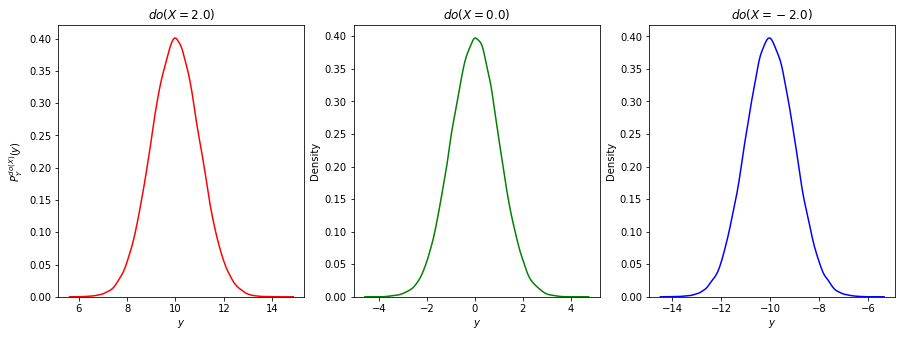

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].set_ylabel("$P_Y^{do(X)}(y)$")

for i in range(3):
    x, y = get_data(100000, 'interventional', 'normal', lambda x: x**3 + x, val_x = xbins[idx[i]])
    sns.distplot(y, hist=False, kde=True, bins=600, color = colors[i], ax = ax[i])
    ax[i].set_xlabel("$y$")
    ax[i].set_title("$do(X = %.1f)$" % xbins[idx[i]])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

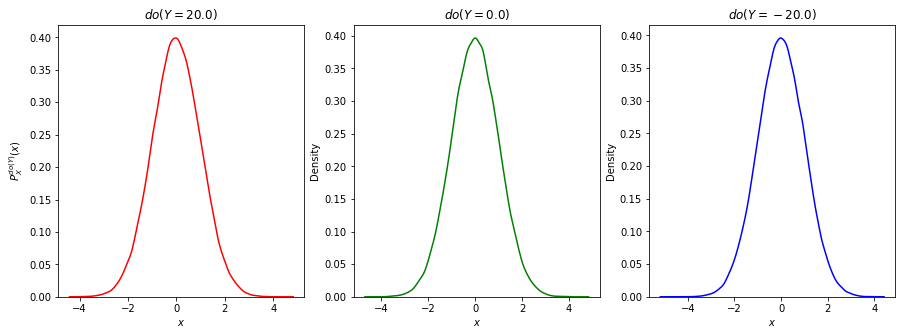

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].set_ylabel("$P_X^{do(Y)}(x)$")

for i in range(3):
    x, y = get_data(100000, 'normal', 'interventional', lambda x: 0, val_y = ybins[idx[i]])
    sns.distplot(x, hist=False, kde=True, bins=600, color = colors[i], ax = ax[i])
    ax[i].set_xlabel("$x$")
    ax[i].set_title("$do(Y = %.1f)$" % ybins[idx[i]])

Intervention on $Y$ does not change the distribution of $X$, and $P_Y^{do(X=x)}(y) = P_{Y|X}(y|x)$. Consequently, we conclude $X \rightarrow Y$, which supports our previous inference. 

##### Causal Discovery

Based on the **identifiability of ANMs** theorem, we know that a distribution generically does not admit an ANM in both directions at the same time. The linear Gaussian model is a case that ANM yields in both directions and causal structure learning is impossible. Therefore, our causal learning method, which is checking the independence of residuals, will work in most experiments:



1.   We regress $Y$ on $X$, and we write $Y$ as a function $\hat{f}_Y$ of $X$ plus some noise.
2.   We test if $Y - \hat{f}_Y$ is independent of $Y$. **Note that we use additivity and $X\perp \!\!\!\! \perp N_Y$ assumptions in the both steps.**
3.   Then we repeat the procedure with exchanging the roles of $X$ and $Y$.
4.   If the independence is accepted for one direction and rejected for the other, we infer the former one as the causal direction.


In [11]:
p_x = []
p_y = []

for i in range(10):
    print('Step', i+1)

    x, y = get_data(200, 'normal', 'normal', lambda x: x**3 + x)
    r_y = fit(np.expand_dims(x, axis=1), y)
    r_x = fit(np.expand_dims(y, axis=1), x)
    p_x.append(Hsic().test(x, r_y, workers = -1)[1])
    p_y.append(Hsic().test(y, r_x, workers = -1)[1])

    print('-> HSIC(x, r_y) p-value =', p_x[-1])
    print('-> HSIC(y, r_x) p-value =', p_y[-1], '\n')

print('HSIC(x, r_y) p-value average = ', sum(p_x) / len(p_x))
print('HSIC(y, r_x) p-value average = ', sum(p_y) / len(p_y))

Step 1
-> HSIC(x, r_y) p-value = 0.189739422434957
-> HSIC(y, r_x) p-value = 3.52181022158098e-05 

Step 2
-> HSIC(x, r_y) p-value = 1.0
-> HSIC(y, r_x) p-value = 8.721778832296844e-05 

Step 3
-> HSIC(x, r_y) p-value = 1.0
-> HSIC(y, r_x) p-value = 9.597353342404663e-06 

Step 4
-> HSIC(x, r_y) p-value = 1.0
-> HSIC(y, r_x) p-value = 0.0002964726335130215 

Step 5
-> HSIC(x, r_y) p-value = 1.0
-> HSIC(y, r_x) p-value = 1.0660657564197857e-05 

Step 6
-> HSIC(x, r_y) p-value = 1.0
-> HSIC(y, r_x) p-value = 0.0013898528760608179 

Step 7
-> HSIC(x, r_y) p-value = 1.0
-> HSIC(y, r_x) p-value = 1.5921954167442695e-05 

Step 8
-> HSIC(x, r_y) p-value = 1.0
-> HSIC(y, r_x) p-value = 1.7936860835732178e-06 

Step 9
-> HSIC(x, r_y) p-value = 0.5534269836385153
-> HSIC(y, r_x) p-value = 0.00018725476992320107 

Step 10
-> HSIC(x, r_y) p-value = 0.9071330859478361
-> HSIC(y, r_x) p-value = 7.265762379420202e-05 

HSIC(x, r_y) p-value average =  0.8650299492021309
HSIC(y, r_x) p-value average = 

Anti-Causal: $Y \rightarrow X$.

### Model B

$X := N_X, Y := X + N_X$
$\newcommand{\indep}{\perp \!\!\! \perp}$

$N_X \indep N_Y$ 

$N_X\sim \mathcal{N}(0, 1),\ N_Y \sim U(0, 1)$

##### Observational Data

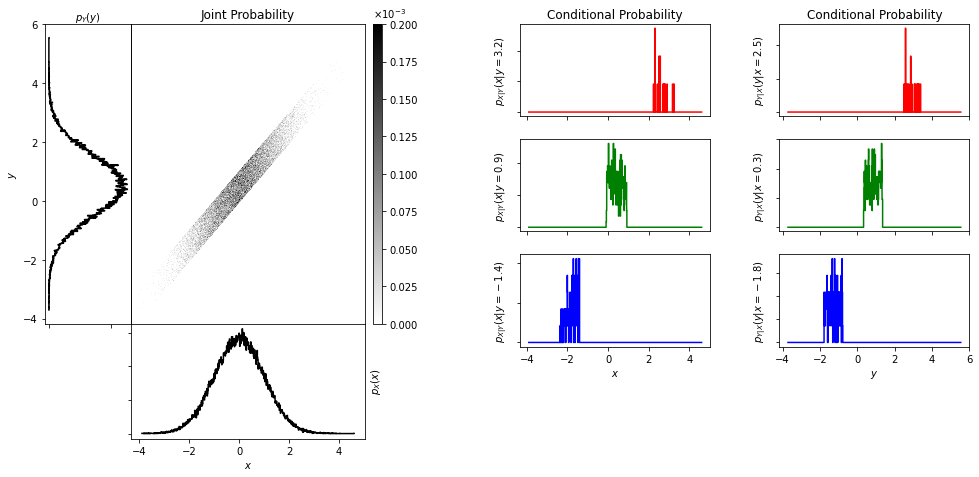

In [12]:
Xgrid = np.linspace(-4, 4, Ngrid + 1)
Ygrid = np.linspace(-8, 8, Ngrid + 1)
xbins, ybins = plot_observational(100000, 'normal', 'uniform', lambda x: x, Ngrid)

##### Interventional Data

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

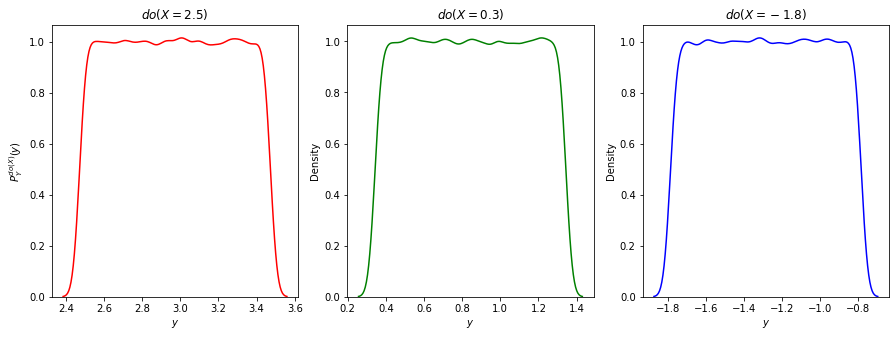

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].set_ylabel("$P_Y^{do(X)}(y)$")

for i in range(3):
    x, y = get_data(100000, 'interventional', 'uniform', lambda x: x, val_x = xbins[idx[i]])
    sns.distplot(y, hist=False, kde=True, bins=600, color = colors[i], ax = ax[i])
    ax[i].set_xlabel("$y$")
    ax[i].set_title("$do(X = %.1f)$" % xbins[idx[i]])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

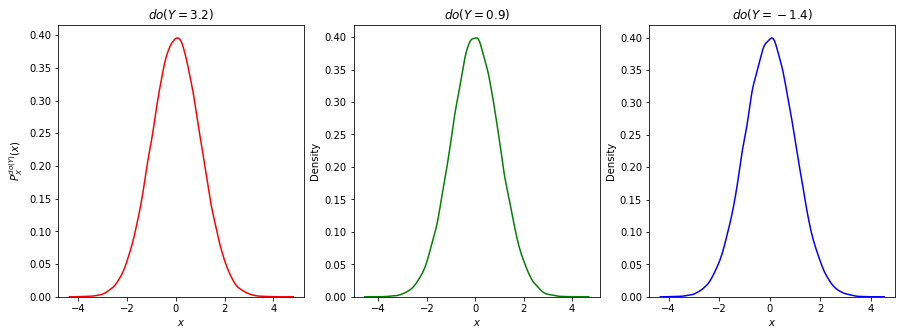

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].set_ylabel("$P_X^{do(Y)}(x)$")

for i in range(3):
    x, y = get_data(100000, 'normal', 'interventional', lambda x: 0, val_y = ybins[idx[i]])
    sns.distplot(x, hist=False, kde=True, bins=600, color = colors[i], ax = ax[i])
    ax[i].set_xlabel("$x$")
    ax[i].set_title("$do(Y = %.1f)$" % ybins[idx[i]])

Intervention on $Y$ does not change the distribution of $X$, and $P_Y^{do(X=x)}(y) = P_{Y|X}(y|x)$. Consequently, we conclude $X \rightarrow Y$, which supports our previous inference. 

##### Causal Discovery

In [15]:
p_x = []
p_y = []

for i in range(10):
    print('Step', i+1)

    x, y = get_data(200, 'normal', 'uniform', lambda x: x)
    r_y = fit(np.expand_dims(x, axis=1), y)
    r_x = fit(np.expand_dims(y, axis=1), x)
    p_x.append(Hsic().test(x, r_y, workers = -1)[1])
    p_y.append(Hsic().test(y, r_x, workers = -1)[1])

    print('-> HSIC(x, r_y) p-value =', p_x[-1])
    print('-> HSIC(y, r_x) p-value =', p_y[-1], '\n')

print('HSIC(x, r_y) p-value average = ', sum(p_x) / len(p_x))
print('HSIC(y, r_x) p-value average = ', sum(p_y) / len(p_y))

Step 1
-> HSIC(x, r_y) p-value = 1.0
-> HSIC(y, r_x) p-value = 0.4015398231803675 

Step 2
-> HSIC(x, r_y) p-value = 1.0
-> HSIC(y, r_x) p-value = 0.15771423690796926 

Step 3
-> HSIC(x, r_y) p-value = 1.0
-> HSIC(y, r_x) p-value = 0.3287326055385955 

Step 4
-> HSIC(x, r_y) p-value = 0.5800511187427757
-> HSIC(y, r_x) p-value = 1.0 

Step 5
-> HSIC(x, r_y) p-value = 1.0
-> HSIC(y, r_x) p-value = 0.3224162766671361 

Step 6
-> HSIC(x, r_y) p-value = 0.7447191770872792
-> HSIC(y, r_x) p-value = 0.2027408246582995 

Step 7
-> HSIC(x, r_y) p-value = 0.26074721129111883
-> HSIC(y, r_x) p-value = 0.43801181014143176 

Step 8
-> HSIC(x, r_y) p-value = 0.47736205665901144
-> HSIC(y, r_x) p-value = 1.0 

Step 9
-> HSIC(x, r_y) p-value = 0.8305170280272289
-> HSIC(y, r_x) p-value = 0.37507017340856585 

Step 10
-> HSIC(x, r_y) p-value = 0.30069425156590557
-> HSIC(y, r_x) p-value = 0.06088202147788547 

HSIC(x, r_y) p-value average =  0.719409084337332
HSIC(y, r_x) p-value average =  0.42871077

Anti-Causal: $Y \rightarrow X$.

$N_X\sim U(0, 1),\ N_Y \sim \mathcal{N}(0, 1)$

##### Observational Data

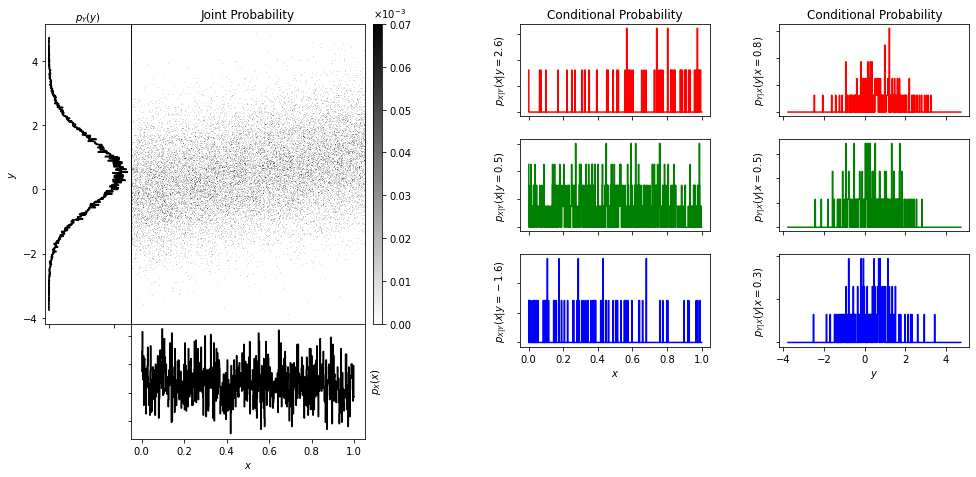

In [16]:
Xgrid = np.linspace(-4, 4, Ngrid + 1)
Ygrid = np.linspace(-8, 8, Ngrid + 1)
xbins, ybins = plot_observational(100000, 'uniform', 'normal', lambda x: x, Ngrid)

##### Interventional Data

C:\Users\Mohammad Reza\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


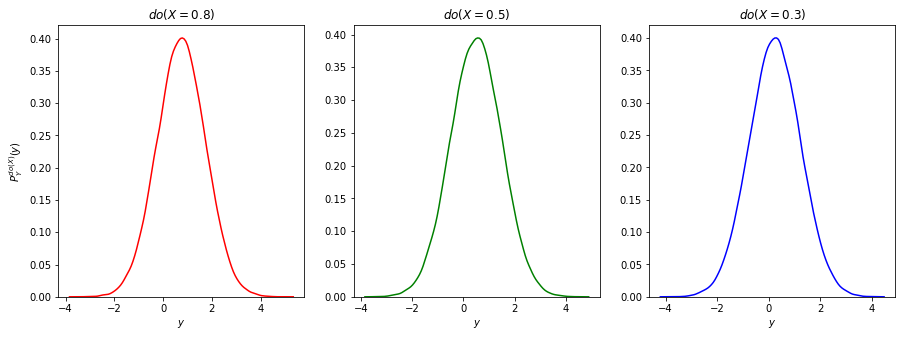

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].set_ylabel("$P_Y^{do(X)}(y)$")

for i in range(3):
    x, y = get_data(100000, 'interventional', 'normal', lambda x: x, val_x = xbins[idx[i]])
    sns.distplot(y, hist=False, kde=True, bins=600, color = colors[i], ax = ax[i])
    ax[i].set_xlabel("$y$")
    ax[i].set_title("$do(X = %.1f)$" % xbins[idx[i]])

C:\Users\Mohammad Reza\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


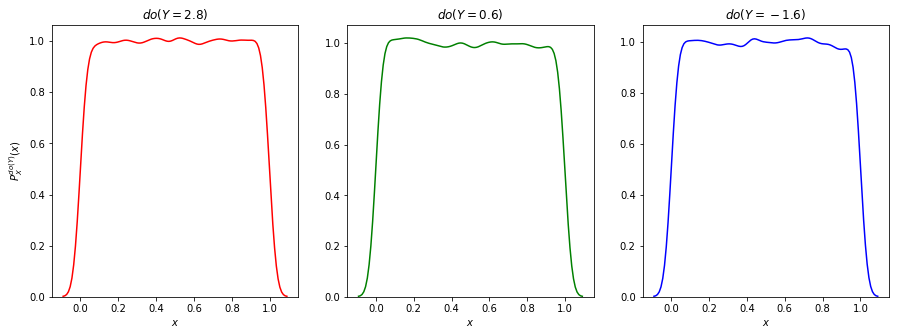

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].set_ylabel("$P_X^{do(Y)}(x)$")

for i in range(3):
    x, y = get_data(100000, 'uniform', 'interventional', lambda x: 0, val_y = ybins[idx[i]])
    sns.distplot(x, hist=False, kde=True, bins=600, color = colors[i], ax = ax[i])
    ax[i].set_xlabel("$x$")
    ax[i].set_title("$do(Y = %.1f)$" % ybins[idx[i]])

Intervention on $Y$ does not change the distribution of $X$, and $P_Y^{do(X=x)}(y) = P_{Y|X}(y|x)$. Consequently, we conclude $X \rightarrow Y$, which supports our previous inference. 

##### Causal Discovery

In [33]:
p_x = []
p_y = []

for i in range(10):
    print('Step', i+1)

    x, y = get_data(200, 'uniform', 'normal', lambda x: x)
    r_y = fit(np.expand_dims(x, axis=1), y)
    r_x = fit(np.expand_dims(y, axis=1), x)
    p_x.append(Hsic().test(x, r_y, workers = -1)[1])
    p_y.append(Hsic().test(y, r_x, workers = -1)[1])

    print('-> HSIC(x, r_y) p-value =', p_x[-1])
    print('-> HSIC(y, r_x) p-value =', p_y[-1], '\n')

print('HSIC(x, r_y) p-value average = ', sum(p_x) / len(p_x))
print('HSIC(y, r_x) p-value average = ', sum(p_y) / len(p_y))

Step 1
-> HSIC(x, r_y) p-value = 0.5402189227383909
-> HSIC(y, r_x) p-value = 0.3238099352800575 

Step 2
-> HSIC(x, r_y) p-value = 1.0
-> HSIC(y, r_x) p-value = 0.07694589662090712 

Step 3
-> HSIC(x, r_y) p-value = 0.17022899937291808
-> HSIC(y, r_x) p-value = 0.0617460854394687 

Step 4
-> HSIC(x, r_y) p-value = 1.0
-> HSIC(y, r_x) p-value = 0.09510470285120518 

Step 5
-> HSIC(x, r_y) p-value = 0.16349483977827328
-> HSIC(y, r_x) p-value = 0.26169586985258236 

Step 6
-> HSIC(x, r_y) p-value = 0.4030024134498552
-> HSIC(y, r_x) p-value = 0.6063218411755286 

Step 7
-> HSIC(x, r_y) p-value = 1.0
-> HSIC(y, r_x) p-value = 0.4781181528899502 

Step 8
-> HSIC(x, r_y) p-value = 0.3454141060338366
-> HSIC(y, r_x) p-value = 0.08711277504500683 

Step 9
-> HSIC(x, r_y) p-value = 0.4638634717441005
-> HSIC(y, r_x) p-value = 0.07038918339814569 

Step 10
-> HSIC(x, r_y) p-value = 1.0
-> HSIC(y, r_x) p-value = 0.031153933946466424 

HSIC(x, r_y) p-value average =  0.6086222753117374
HSIC(y, r

Anti-Causal: $Y \rightarrow X$.

$N_X\sim \mathcal{N}(0, 1),\ N_Y \sim$ Student's t-Distribution with degree of freedom $= 1$

##### Observational Data

C:\Users\Mohammad Reza\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


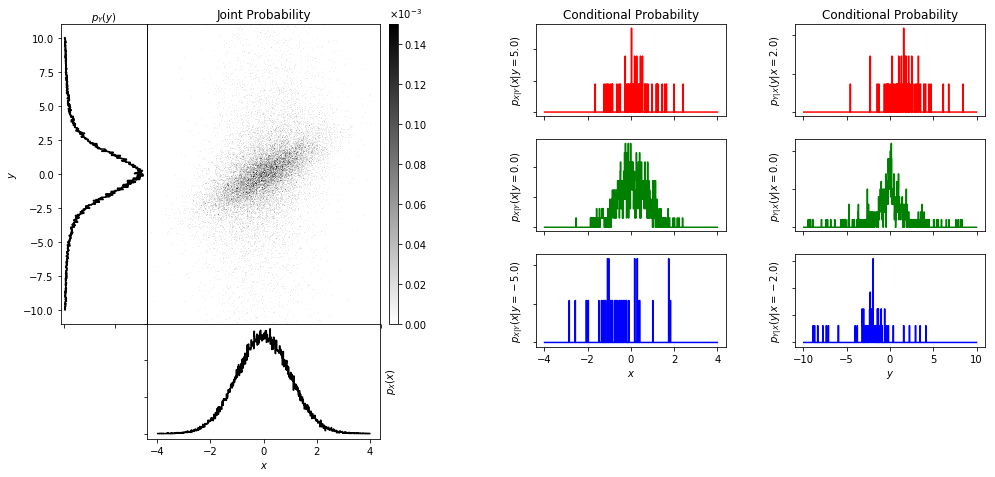

In [ ]:
Xgrid = np.linspace(-4, 4, Ngrid + 1)
Ygrid = np.linspace(-10, 10, Ngrid + 1)
xbins, ybins = plot_observational(100000, 'normal', 't dist', lambda x: x, Ngrid, Xgrid, Ygrid, df = 1)

##### Interventional Data

C:\Users\Mohammad Reza\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


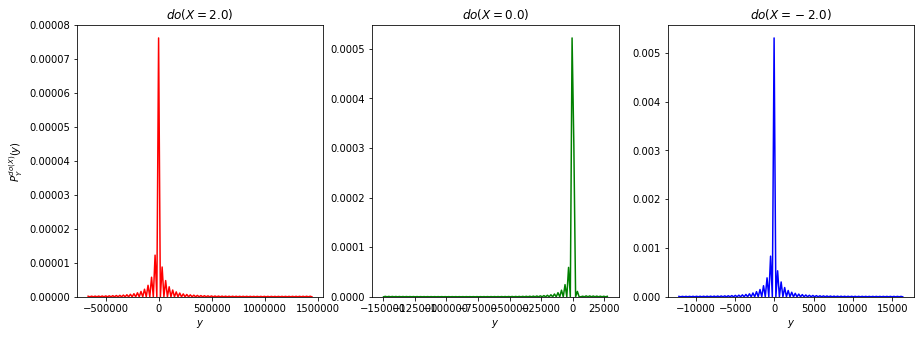

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].set_ylabel("$P_Y^{do(X)}(y)$")

for i in range(3):
    x, y = get_data(100000, 'interventional', 't dist', lambda x: x, val_x = xbins[idx[i]], df = 1)
    sns.distplot(y, hist=False, kde=True, bins=600, color = colors[i], ax = ax[i])
    ax[i].set_xlabel("$y$")
    ax[i].set_title("$do(X = %.1f)$" % xbins[idx[i]])

C:\Users\Mohammad Reza\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


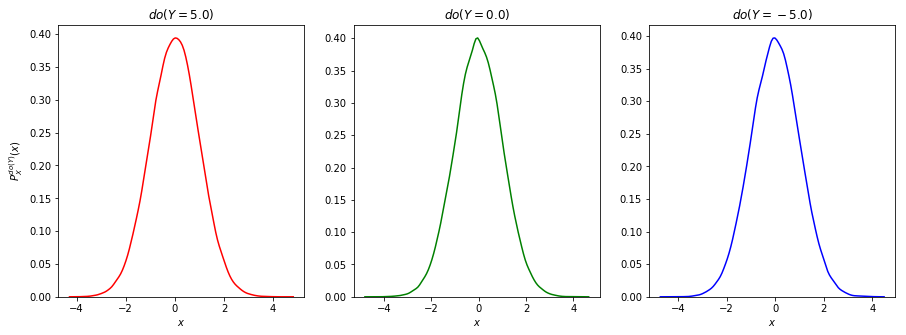

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].set_ylabel("$P_X^{do(Y)}(x)$")

for i in range(3):
    x, y = get_data(100000, 'normal', 'interventional', lambda x: 0, val_y = ybins[idx[i]])
    sns.distplot(x, hist=False, kde=True, bins=600, color = colors[i], ax = ax[i])
    ax[i].set_xlabel("$x$")
    ax[i].set_title("$do(Y = %.1f)$" % ybins[idx[i]])

Intervention on $Y$ does not change the distribution of $X$, and $P_Y^{do(X=x)}(y) = P_{Y|X}(y|x)$. Consequently, we conclude $X \rightarrow Y$, which supports our previous inference. 

##### Causal Discovery

In [35]:
p_x = []
p_y = []

for i in range(10):
    print('Step', i+1)

    x, y = get_data(200, 'normal', 't dist', lambda x: x, df = 1)
    r_y = fit(np.expand_dims(x, axis=1), y)
    r_x = fit(np.expand_dims(y, axis=1), x)
    p_x.append(Hsic().test(x, r_y, workers = -1)[1])
    p_y.append(Hsic().test(y, r_x, workers = -1)[1])

    print('-> HSIC(x, r_y) p-value =', p_x[-1])
    print('-> HSIC(y, r_x) p-value =', p_y[-1], '\n')

print('HSIC(x, r_y) p-value average = ', sum(p_x) / len(p_x))
print('HSIC(y, r_x) p-value average = ', sum(p_y) / len(p_y))

Step 1
-> HSIC(x, r_y) p-value = 1.0
-> HSIC(y, r_x) p-value = 0.018705123186506162 

Step 2
-> HSIC(x, r_y) p-value = 1.0
-> HSIC(y, r_x) p-value = 0.050059845795471646 

Step 3
-> HSIC(x, r_y) p-value = 0.5658278067254578
-> HSIC(y, r_x) p-value = 0.09276981343038904 

Step 4
-> HSIC(x, r_y) p-value = 0.17304080591364474
-> HSIC(y, r_x) p-value = 0.0043103561556376855 

Step 5
-> HSIC(x, r_y) p-value = 1.0
-> HSIC(y, r_x) p-value = 0.008366763927969239 

Step 6
-> HSIC(x, r_y) p-value = 1.0
-> HSIC(y, r_x) p-value = 0.04786758123022795 

Step 7
-> HSIC(x, r_y) p-value = 0.48424701355645794
-> HSIC(y, r_x) p-value = 0.10021791452933307 

Step 8
-> HSIC(x, r_y) p-value = 0.5201528671012019
-> HSIC(y, r_x) p-value = 0.007074075128981522 

Step 9
-> HSIC(x, r_y) p-value = 0.19911722078657057
-> HSIC(y, r_x) p-value = 0.03922314583048 

Step 10
-> HSIC(x, r_y) p-value = 1.0
-> HSIC(y, r_x) p-value = 0.022077218816012108 

HSIC(x, r_y) p-value average =  0.6942385714083332
HSIC(y, r_x) p-v

Anti-Causal: $Y \rightarrow X$.

$N_X\sim \mathcal{N}(0, 1),\ N_Y \sim$ Student's t-Distribution with degree of freedom $= 20$

##### Observational Data

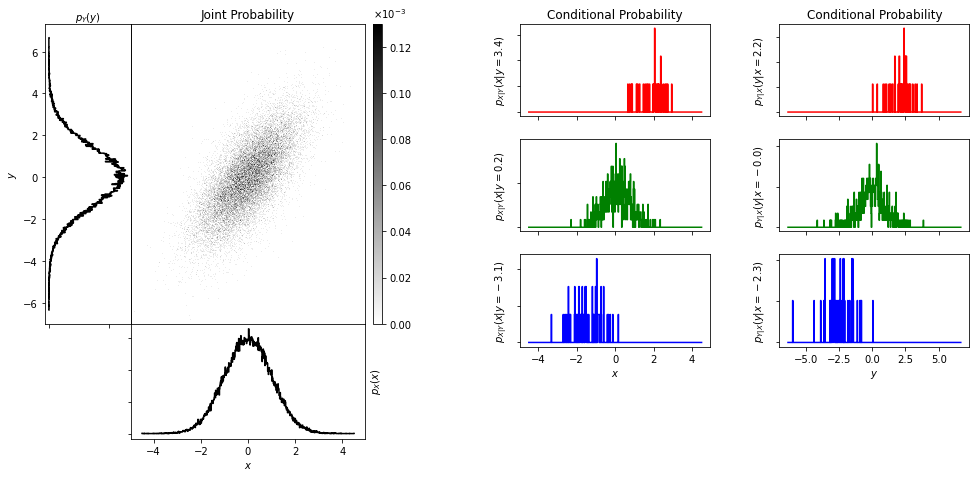

In [34]:
Xgrid = np.linspace(-4, 4, Ngrid + 1)
Ygrid = np.linspace(-100, 100, Ngrid + 1)
xbins, ybins = plot_observational(100000, 'normal', 't dist', lambda x: x, Ngrid, df = 20)

##### Interventional Data

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

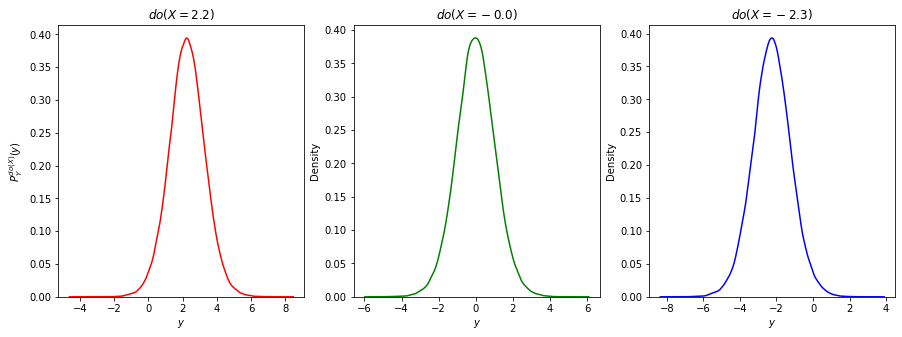

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].set_ylabel("$P_Y^{do(X)}(y)$")

for i in range(3):
    x, y = get_data(100000, 'interventional', 't dist', lambda x: x, val_x = xbins[idx[i]], df = 20)
    sns.distplot(y, hist=False, kde=True, bins=600, color = colors[i], ax = ax[i])
    ax[i].set_xlabel("$y$")
    ax[i].set_title("$do(X = %.1f)$" % xbins[idx[i]])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

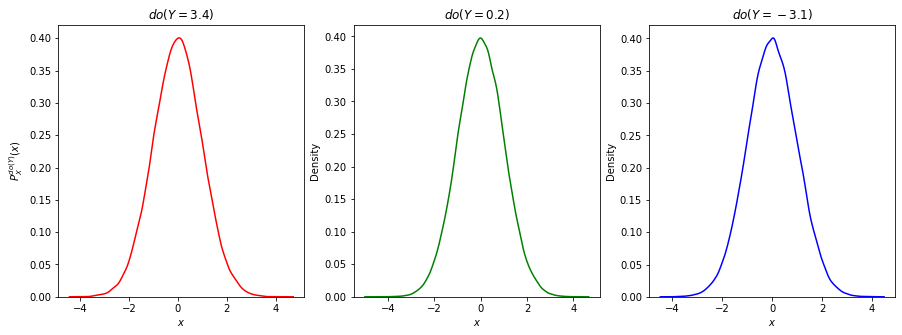

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].set_ylabel("$P_X^{do(Y)}(x)$")

for i in range(3):
    x, y = get_data(100000, 'normal', 'interventional', lambda x: 0, val_y = ybins[idx[i]])
    sns.distplot(x, hist=False, kde=True, bins=600, color = colors[i], ax = ax[i])
    ax[i].set_xlabel("$x$")
    ax[i].set_title("$do(Y = %.1f)$" % ybins[idx[i]])

Intervention on $Y$ does not change the distribution of $X$, and $P_Y^{do(X=x)}(y) = P_{Y|X}(y|x)$. Consequently, we conclude $X \rightarrow Y$, which supports our previous inference. 

##### Causal Discovery

In [47]:
p_x = []
p_y = []

for i in range(10):
    print('Step', i+1)

    x, y = get_data(200, 'normal', 't dist', lambda x: x, df = 20)
    r_y = fit(np.expand_dims(x, axis=1), y)
    r_x = fit(np.expand_dims(y, axis=1), x)
    p_x.append(Hsic().test(x, r_y, workers = -1)[1])
    p_y.append(Hsic().test(y, r_x, workers = -1)[1])

    print('-> HSIC(x, r_y) p-value =', p_x[-1])
    print('-> HSIC(y, r_x) p-value =', p_y[-1], '\n')

print('HSIC(x, r_y) p-value average = ', sum(p_x) / len(p_x))
print('HSIC(y, r_x) p-value average = ', sum(p_y) / len(p_y))

Step 1
-> HSIC(x, r_y) p-value = 1.0
-> HSIC(y, r_x) p-value = 0.1816308034723112 

Step 2
-> HSIC(x, r_y) p-value = 1.0
-> HSIC(y, r_x) p-value = 0.7685187863147661 

Step 3
-> HSIC(x, r_y) p-value = 0.42927762050454266
-> HSIC(y, r_x) p-value = 1.0 

Step 4
-> HSIC(x, r_y) p-value = 0.8376006856831653
-> HSIC(y, r_x) p-value = 1.0 

Step 5
-> HSIC(x, r_y) p-value = 0.6071802951746832
-> HSIC(y, r_x) p-value = 0.47058920183985475 

Step 6
-> HSIC(x, r_y) p-value = 0.6117110319388203
-> HSIC(y, r_x) p-value = 0.39144278877755234 

Step 7
-> HSIC(x, r_y) p-value = 1.0
-> HSIC(y, r_x) p-value = 0.6682980286501411 

Step 8
-> HSIC(x, r_y) p-value = 1.0
-> HSIC(y, r_x) p-value = 1.0 

Step 9
-> HSIC(x, r_y) p-value = 0.2625786648753783
-> HSIC(y, r_x) p-value = 0.4481284526387942 

Step 10
-> HSIC(x, r_y) p-value = 1.0
-> HSIC(y, r_x) p-value = 0.7844030635679695 

HSIC(x, r_y) p-value average =  0.774834829817659
HSIC(y, r_x) p-value average =  0.671301112526139



Independence is plausible in both directions, so we can not infer the causal direction. That is because the model is so close to the linear Gaussian model.

### Old Faithful Geyser

In [9]:
eruptions = []
waitings = []

with open ('./data/Old Faithful Geyser.txt' , 'r') as f:
    lines = f.readlines()
    for line in lines:
        i, eruption, waiting = line.split()
        eruptions.append(float(eruption))
        waitings.append(float(waiting))
        
eruptions = np.array(eruptions)
waitings = np.array(waitings)

##### Plot Data

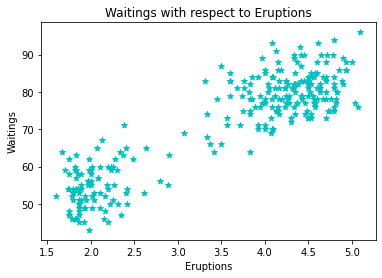

In [13]:
plt.xlabel("Eruptions")
plt.ylabel("Waitings")
plt.title("Waitings with respect to Eruptions")
_ = plt.scatter(eruptions, waitings, c = 'c', marker='*')

##### Causal Discovery

In [13]:
r_waitings = fit(np.expand_dims(eruptions, axis=1), waitings)
r_eruptions = fit(np.expand_dims(waitings, axis=1), eruptions)

print('HSIC(eruptions, r_waitings) p-value =', Hsic().test(eruptions, r_waitings, workers = -1)[1])
print('HSIC(waitings, r_eruptions) p-value =', Hsic().test(waitings, r_eruptions, workers = -1)[1])

HSIC(eruptions, r_waitings) p-value = 1.0
HSIC(waitings, r_eruptions) p-value = 0.0005396209905119277


$Eruption \rightarrow Waiting$

### Tübingen Cause-Effect Pairs

In [13]:
def read_pair(index):
    X = []
    Y = []

    with open ('./data/tuebingen/pair{}.txt'.format(index) , 'r') as f:
        lines = f.readlines()
        for line in lines:
            x, y = line.split()
            X.append(float(x))
            Y.append(float(y))

    xy = None

    with open ('./data/tuebingen/pair{}_des.txt'.format(index) , 'r') as f:
        lines = f.readlines()
        for line in lines:
            if 'x --> y' in line or 'x-->y' in line:
                xy = True
                break
            if 'y --> x' in line or 'y-->x' in line:
                xy = False
            
    return np.array(X), np.array(Y), xy

##### Causal Discovery

In [14]:
for i in range(1, 50):
    index = str(i).zfill(4)
    print('===> pair{}'.format(index))

    x, y, xy = read_pair(index)
    r_y = fit(np.expand_dims(x, axis = 1), y)
    r_x = fit(np.expand_dims(y, axis = 1), x)
    pval_x = Hsic().test(x, r_y, workers = -1)[1]
    pval_y = Hsic().test(y, r_x, workers = -1)[1]

    if pval_x < pval_y:
        print('y --> x', not xy, '\n')
    else:
        print('x --> y', xy, '\n')

===> pair0001
y --> x False 

===> pair0002
x --> y True 

===> pair0003
y --> x False 

===> pair0004
y --> x False 

===> pair0005
x --> y True 

===> pair0006
y --> x False 

===> pair0007
y --> x False 

===> pair0008
y --> x False 

===> pair0009
y --> x False 

===> pair0010
y --> x False 

===> pair0011
y --> x False 

===> pair0012
y --> x False 

===> pair0013
x --> y True 

===> pair0014
y --> x False 

===> pair0015
y --> x False 

===> pair0016
x --> y True 

===> pair0017
y --> x False 

===> pair0018
x --> y True 

===> pair0019
x --> y True 

===> pair0020
y --> x False 

===> pair0021
x --> y True 

===> pair0022
x --> y True 

===> pair0023
x --> y True 

===> pair0024
x --> y True 

===> pair0025
x --> y True 

===> pair0026
y --> x False 

===> pair0027
y --> x False 

===> pair0028
x --> y True 

===> pair0029
x --> y True 

===> pair0030
y --> x False 

===> pair0031
y --> x False 

===> pair0032
x --> y True 

===> pair0033
x --> y True 

===> pair0034
x --> y Tru

We examine a case in which our approach failed to reason correctly. In dataset $20$, $X$ causes $Y$; however, the exogenous noise is not independent of $X$, as you see in the following graph. This is in contrast with the method's assumption, and as a result, it fails. 


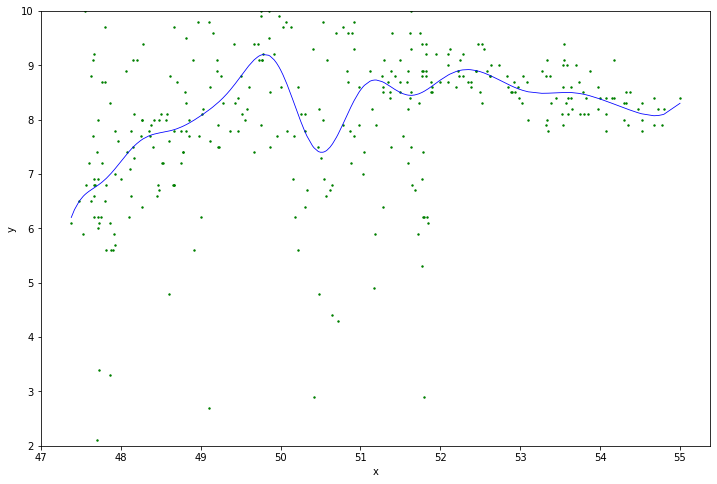

In [31]:
index = str(20).zfill(4)
x, y, ground_truth = read_pair(index)
svr = SVR(kernel = 'rbf', C = 1000, gamma = 'auto', epsilon = 0.1, coef0 = 1)
svr.fit(np.expand_dims(x, axis=1), y)

plt.figure(figsize = (12, 8))
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(2, 10)
plt.scatter(x, y, marker='o', s = 2, c = 'g')
plt.plot(np.sort(x),svr.predict(np.expand_dims(np.sort(x),axis=1)), c='blue', linewidth=0.8)
plt.show()

## Graph Discovery

In [23]:
X, Y, Z, W = [], [], [], []

with open ('./data/TwoVarData.txt' , 'r') as f:
    lines = f.readlines()
    for line in lines[1:]:
        i, x, y, z, w = line.split()
        X.append(float(x))
        Y.append(float(y))
        Z.append(float(z))
        W.append(float(w))

x, y, z, w = np.array(X), np.array(Y), np.array(Z), np.array(W)

In [24]:
r_y = fit(np.expand_dims(x, axis = 1), y)
r_x = fit(np.expand_dims(y, axis = 1), x)
pval_x = Hsic().test(x, r_y, workers = -1)[1]
pval_y = Hsic().test(y, r_x, workers = -1)[1]

if pval_x <= pval_y:
    print('y --> x\n')
else:
    print('x --> y\n')

x --> y



In [25]:
r_y = fit(np.expand_dims(w, axis = 1), y)
r_w = fit(np.expand_dims(y, axis = 1), w)
pval_w = Hsic().test(w, r_y, workers = -1)[1]
pval_y = Hsic().test(y, r_w, workers = -1)[1]

if pval_w <= pval_y:
    print('y --> w\n')
else:
    print('w --> y\n')

y --> w



In [27]:
r_x = fit(np.expand_dims(w, axis = 1), x)
r_w = fit(np.expand_dims(x, axis = 1), w)
pval_w = Hsic().test(w, r_x, workers = -1)[1]
pval_x = Hsic().test(x, r_w, workers = -1)[1]

if pval_w <= pval_x:
    print('x --> w\n')
else:
    print('w --> x\n')

x --> w



In [28]:
r_x = fit(np.expand_dims(z, axis = 1), x)
r_z = fit(np.expand_dims(x , axis = 1), z)
pval_z = Hsic().test(z, r_x, workers = -1)[1]
pval_x = Hsic().test(x, r_z, workers = -1)[1]

if pval_z <= pval_x:
    print('x --> z\n')
else:
    print('z --> x\n')

x --> z



In [30]:
r_y = fit(np.expand_dims(z, axis = 1), y)
r_z = fit(np.expand_dims(y , axis = 1), z)
pval_z = Hsic().test(z, r_y, workers = -1)[1]
pval_y = Hsic().test(y, r_z, workers = -1)[1]

if pval_y <= pval_z:
    print('z --> y\n')
else:
    print('y --> z\n')

y --> z

